# Notebook to manually tune sequnce models and add click 0 data and add Zip Code

In [1]:
import numpy as np
import pandas as pd
import s3fs
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Concatenate, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
import pyarrow
import boto3
import pyarrow.parquet as pq
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report, average_precision_score, 
                             precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve, plot_roc_curve)
from matplotlib import pyplot as plt
import pickle
from focal_loss import BinaryFocalLoss

In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 0)
s3 = s3fs.S3FileSystem()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) # wide notebook display

### Now we use all the data click stream data

In [4]:
feature_path = 's3://aap-aiexpzone-pii-mktg-datascientist-results-prod/ScottSmith/may_2021_page_action_no_checkout_leakage.parquet'

In [5]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we read in all the click 0 data

In [6]:
click0_path = 's3://aap-aiexpzone-pii-mktg-diymktganalyst-results-prod/bfeichtl/projectDiscountPreference/click_0_data/2021_1_9.parquet'

In [7]:
click0_table = pq.ParquetDataset(click0_path, filesystem=s3).read_pandas().to_pandas()

In [8]:
len(feature_table), len(click0_table)

(5870027, 15573579)

In [9]:
click0_table.dtypes

eventtime                               object
udo_tealium_session_id                  object
clientip                                object
firstpartycookies_channeloriginator     object
firstpartycookies_utag_main__pn         object
firstpartycookies_utag_main_dc_event    object
firstpartycookies_utag_main_dc_visit    object
udo_as_customer_acquisition_status      object
udo_customer_status                     object
udo_loyalty_tier                        object
udo_site_type                           object
udo_ut_event                            object
udo_zip                                 object
dtype: object

In [10]:
feature_table = feature_table.merge(click0_table, how='left', on='udo_tealium_session_id')

In [11]:
feature_table.isna().sum()

udo_tealium_session_id                  0      
TYPE_SENTENCE                           0      
NAME_SENTENCE                           0      
CATEGORY_SENTENCE                       0      
ACTION_SENTENCE                         0      
LABEL_SENTENCE                          0      
DWELL_SENTENCE                          0      
LABEL                                   0      
eventtime                               0      
clientip                                0      
firstpartycookies_channeloriginator     2348379
firstpartycookies_utag_main__pn         0      
firstpartycookies_utag_main_dc_event    0      
firstpartycookies_utag_main_dc_visit    0      
udo_as_customer_acquisition_status      0      
udo_customer_status                     77937  
udo_loyalty_tier                        5372737
udo_site_type                           79265  
udo_ut_event                            0      
udo_zip                                 2670334
dtype: int64

In [12]:
feature_table.fillna('NULL', inplace=True)

In [13]:
feature_table.columns

Index(['udo_tealium_session_id', 'TYPE_SENTENCE', 'NAME_SENTENCE',
       'CATEGORY_SENTENCE', 'ACTION_SENTENCE', 'LABEL_SENTENCE',
       'DWELL_SENTENCE', 'LABEL', 'eventtime', 'clientip',
       'firstpartycookies_channeloriginator',
       'firstpartycookies_utag_main__pn',
       'firstpartycookies_utag_main_dc_event',
       'firstpartycookies_utag_main_dc_visit',
       'udo_as_customer_acquisition_status', 'udo_customer_status',
       'udo_loyalty_tier', 'udo_site_type', 'udo_ut_event', 'udo_zip'],
      dtype='object')

### Now we evaluate the class balance

In [14]:
summary = feature_table.groupby('LABEL')['udo_tealium_session_id'].count().reset_index()

In [15]:
summary['FRACTION'] = summary['udo_tealium_session_id']/summary['udo_tealium_session_id'].sum()

In [16]:
summary

LABEL  udo_tealium_session_id             FRACTION
0  0      5542030                               0.944
1  1      327997                                0.056

In [17]:
class_weight_postive = summary[summary.LABEL==0]['FRACTION'].values [0]

In [18]:
class_weight_negative = summary[summary.LABEL==1]['FRACTION'].values [0]

In [19]:
class_weight_postive

0.9441234256673777

In [20]:
class_weight_negative

0.05587657433262232

In [21]:
class_weight_dict = {0: class_weight_negative, 
                     1: class_weight_postive}

### Now split the data into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(feature_table[['TYPE_SENTENCE', 'NAME_SENTENCE', 'CATEGORY_SENTENCE', 
                                                                   'ACTION_SENTENCE', 'LABEL_SENTENCE', 'DWELL_SENTENCE',
                                                                   'clientip', 'firstpartycookies_channeloriginator', 
                                                                   'firstpartycookies_utag_main__pn','firstpartycookies_utag_main_dc_event',
                                                                   'firstpartycookies_utag_main_dc_visit', 'udo_as_customer_acquisition_status', 
                                                                   'udo_customer_status', 'udo_loyalty_tier', 'udo_site_type', 'udo_zip']], feature_table['LABEL'], 
                                                                   test_size=0.10, random_state=1, stratify=feature_table['LABEL'])

### Prepare sequences for modeling.  Note that we pass the fit tokenizer when we prepare the test sequences

#### We create an empty dictionary.  The keys will be the sentence name, the values will be the train and test indicies

In [23]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

In [24]:
data_dict = read_pickle_from_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_sequence_dict.pkl')

### We will now use StringLookup to assign each unique ip address an integer index.  We will only use the most comon 40,000 ip addresses

In [25]:
ip_vocab = read_pickle_from_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_ip_vocab.pkl')

In [26]:
ip_indicies = tensorflow.keras.layers.StringLookup(max_tokens=40000,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=ip_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="int",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

### Write the vocab of the ip addresses to s3

In [27]:
len(ip_indicies.get_vocabulary()), len(ip_vocab)

(40000, 40000)

In [28]:
X_ip_train = ip_indicies(X_train['clientip'])

In [29]:
X_ip_train[0:100]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([    0, 18058,     0,     0,     0,     0,     0,     0,     0,
           0,     0, 21814,     0,  2290,     0,  4026,     0,   230,
           0,     0, 14226,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 17293,     0,     0,     0,
           0,     0,     0,     0,  6033,     0,     0, 23342,     0,
           0,     0,     0,  1828,     0,     0,     0,     0,     0,
           0,     0,     0,  1991,     0, 25218,     0,     0,     0,
           0,     0,     0,   669,  3376,     0,   684,     0,     0,
           0,     0,     7,  6990,     0,     0,     0,     0, 15012,
           0,     0,     0,     0, 22113,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0, 13698,     0,     1,
           0])>

In [30]:
X_ip_test = ip_indicies(X_test['clientip'])

In [31]:
X_ip_test[0:100]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([ 9925,     0,     0,     0,  4236, 39277,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  9495,     0,     0,     0,     0,     0,
           0,     0,     0,     0,  8890,     0,  4235,  6950,     0,
           0,     0,     0,     0,     0,     0,     0,     0,  3618,
           0,   595,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  7160,     0, 10140,     0,  2625,     0,
        2982,     0,     0, 36496,     0,     0, 13557,     0, 36911,
           0,     0,     0,     0,     0,     0,  3123,     0,     0,
        3633,     0, 21002,     0,     0,  6511,     0,     0,     0,
       35884,     0,     0,     0,     0,     0,     0,     0,     0,
       31237])>

### We will now use StringLookup to assign each unique zip code an integer index.  We will only use the most comon 30,000 zip codes

In [32]:
zip_vocab = read_pickle_from_s3(bucket='aap-aiexpzone-pii-mktg-datascientist-results-prod', key='ScottSmith/may_2021_zip_vocab.pkl')

In [33]:
zip_indicies = tensorflow.keras.layers.StringLookup(max_tokens=30000,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=zip_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="int",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

### Write the vocab of the zip codes to s3

In [34]:
X_zip_train = zip_indicies(X_train['udo_zip'])

In [35]:
X_zip_train[0:100]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([    1,  1988,     1,    46,   852,     2,  7485,    25,    55,
        1821,  5183,  3192,     1,     1,     1,     1,   296,     1,
           2,     1,     1,   870,     1,     1,     1,     1,     2,
        4254,     1,    57,  4739,   105,    79,   584,     1,   946,
          16,     1,     1,   268,  5108,  2383,     1,     1,     1,
           1,  6101,     1,     1,  5570,     1,   924,  4222,     1,
           1,  1731,   132,     1,   379, 14518,     1,  3093,   416,
        5767,     1,  4670,     1,     1,     1,     2,     1,  4515,
        5551,     1,     1,     8,     1,     1,   184,  3316,     1,
           1,     1,     1,  1794,   955,     1,   715,    50,  4448,
           1,     7,     1,     1,  3616,   451,   282,     1,     1,
           1])>

In [36]:
X_zip_test = zip_indicies(X_test['udo_zip'])

In [37]:
X_zip_test[0:100]

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([11381,   377,     1,     1,  1228,     1,     1,  2744,     1,
           1,   214,     1,  2156,     1,     1,   336,    27,    12,
           8, 10980,  6495,     1,     1,    15,     1,  3393,     1,
         221,     1,     1,     1,  6779,  9285,  2449,     1,  2188,
           1,     2,   639,     2,  1496,   523,  3409,     1,   389,
        3574,     5,  2899,     1,     1,     1,     1,     1,     5,
           1,   620,   353,     1,  3287,   295,     1,     1,   667,
           1,  5857,   462,  3202,    17,     1,  3488,  8838,    22,
         500,     1,     1,   172, 12092, 23538,     1,     1,   341,
        4131,  2911,     1,     1,   125,     1,   408,     1,     1,
           1,  6953,  2482,     1, 18521,   387,  1819,   473,     1,
        3479])>

### We will now use StringLookup to one-hot encode SP tier

In [38]:
X_train.groupby('udo_loyalty_tier').count()

TYPE_SENTENCE  NAME_SENTENCE  CATEGORY_SENTENCE  \
udo_loyalty_tier                                                    
CLUB              210816         210816         210816              
ELITE             110745         110745         110745              
NULL              4835568        4835568        4835568             
VIP               125895         125895         125895              

                  ACTION_SENTENCE  LABEL_SENTENCE  DWELL_SENTENCE  clientip  \
udo_loyalty_tier                                                              
CLUB              210816           210816          210816          210816     
ELITE             110745           110745          110745          110745     
NULL              4835568          4835568         4835568         4835568    
VIP               125895           125895          125895          125895     

                  firstpartycookies_channeloriginator  \
udo_loyalty_tier                                        
CLUB              210816                                
ELITE             110745                                
NULL              4835568                               
VIP               125895                                

                  firstpartycookies_utag_main__pn  \
udo_loyalty_tier                                    
CLUB              210816                            
ELITE             110745                            
NULL              4835568                           
VIP               125895                            

                  firstpartycookies_utag_main_dc_event  \
udo_loyalty_tier                                         
CLUB              210816                                 
ELITE             110745                                 
NULL              4835568                                
VIP               125895                                 

                  firstpartycookies_utag_main_dc_visit  \
udo_loyalty_tier                                         
CLUB              210816                                 
ELITE             110745                                 
NULL              4835568                                
VIP               125895                                 

                  udo_as_customer_acquisition_status  udo_customer_status  \
udo_loyalty_tier                                                            
CLUB              210816                              210816                
ELITE             110745                              110745                
NULL              4835568                             4835568               
VIP               125895                              125895                

                  udo_site_type  udo_zip  
udo_loyalty_tier                          
CLUB              210816         210816   
ELITE             110745         110745   
NULL              4835568        4835568  
VIP               125895         125895

In [39]:
tier_vocab = ['CLUB', 'ELITE', 'NULL', 'VIP']

In [40]:
sp_oh = tensorflow.keras.layers.StringLookup(max_tokens=None,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=tier_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="one_hot",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

In [41]:
X_sp_train = sp_oh(X_train['udo_loyalty_tier'])

In [42]:
X_sp_train[0:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

In [43]:
X_sp_test = sp_oh(X_test['udo_loyalty_tier'])

In [44]:
X_sp_test[0:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)>

### We will now use StringLookup to one-hot encode whether a customer is new or returning

In [45]:
X_train.groupby('udo_as_customer_acquisition_status').count()

TYPE_SENTENCE  NAME_SENTENCE  \
udo_as_customer_acquisition_status                                 
new                                 4650216        4650216         
repeat                              632808         632808          

                                    CATEGORY_SENTENCE  ACTION_SENTENCE  \
udo_as_customer_acquisition_status                                       
new                                 4650216            4650216           
repeat                              632808             632808            

                                    LABEL_SENTENCE  DWELL_SENTENCE  clientip  \
udo_as_customer_acquisition_status                                             
new                                 4650216         4650216         4650216    
repeat                              632808          632808          632808     

                                    firstpartycookies_channeloriginator  \
udo_as_customer_acquisition_status                                        
new                                 4650216                               
repeat                              632808                                

                                    firstpartycookies_utag_main__pn  \
udo_as_customer_acquisition_status                                    
new                                 4650216                           
repeat                              632808                            

                                    firstpartycookies_utag_main_dc_event  \
udo_as_customer_acquisition_status                                         
new                                 4650216                                
repeat                              632808                                 

                                    firstpartycookies_utag_main_dc_visit  \
udo_as_customer_acquisition_status                                         
new                                 4650216                                
repeat                              632808                                 

                                    udo_customer_status  udo_loyalty_tier  \
udo_as_customer_acquisition_status                                          
new                                 4650216              4650216            
repeat                              632808               632808             

                                    udo_site_type  udo_zip  
udo_as_customer_acquisition_status                          
new                                 4650216        4650216  
repeat                              632808         632808

In [46]:
cust_vocab = ['new', 'repeat']

In [47]:
cust_oh = tensorflow.keras.layers.StringLookup(max_tokens=None,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=cust_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="one_hot",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

In [48]:
X_cust_train = cust_oh(X_train['udo_as_customer_acquisition_status'])

In [49]:
X_cust_train[0:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [50]:
X_cust_test = cust_oh(X_test['udo_as_customer_acquisition_status'])

In [51]:
X_cust_test[0:10]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

### We will now use StringLookup to one-hot encode which channel was the entry point of the session

In [52]:
X_train.groupby('firstpartycookies_channeloriginator').count()

TYPE_SENTENCE  NAME_SENTENCE  \
firstpartycookies_channeloriginator                                 
NULL                                 2113123        2113123         
cj                                   43             43              
cpc                                  279554         279554          
display                              9873           9873            
email                                3174           3174            
ir                                   112289         112289          
referrer                             2764957        2764957         
wolterskluwer                        11             11              

                                     CATEGORY_SENTENCE  ACTION_SENTENCE  \
firstpartycookies_channeloriginator                                       
NULL                                 2113123            2113123           
cj                                   43                 43                
cpc                                  279554             279554            
display                              9873               9873              
email                                3174               3174              
ir                                   112289             112289            
referrer                             2764957            2764957           
wolterskluwer                        11                 11                

                                     LABEL_SENTENCE  DWELL_SENTENCE  clientip  \
firstpartycookies_channeloriginator                                             
NULL                                 2113123         2113123         2113123    
cj                                   43              43              43         
cpc                                  279554          279554          279554     
display                              9873            9873            9873       
email                                3174            3174            3174       
ir                                   112289          112289          112289     
referrer                             2764957         2764957         2764957    
wolterskluwer                        11              11              11         

                                     firstpartycookies_utag_main__pn  \
firstpartycookies_channeloriginator                                    
NULL                                 2113123                           
cj                                   43                                
cpc                                  279554                            
display                              9873                              
email                                3174                              
ir                                   112289                            
referrer                             2764957                           
wolterskluwer                        11                                

                                     firstpartycookies_utag_main_dc_event  \
firstpartycookies_channeloriginator                                         
NULL                                 2113123                                
cj                                   43                                     
cpc                                  279554                                 
display                              9873                                   
email                                3174                                   
ir                                   112289                                 
referrer                             2764957                                
wolterskluwer                        11                                     

                                     firstpartycookies_utag_main_dc_visit  \
firstpartycookies_channeloriginator                                         
NULL                                 2113123                                
cj                                   43                      

In [53]:
channel_vocab = ['NULL', 'cj', 'cpc', 'display', 'email', 'ir', 'referrer', 'wolterskluwer']

In [54]:
channel_oh = tensorflow.keras.layers.StringLookup(max_tokens=None,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=channel_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="one_hot",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

In [55]:
X_channel_train = channel_oh(X_train['firstpartycookies_channeloriginator'])

In [56]:
X_channel_train[0:10]

<tf.Tensor: shape=(10, 9), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)>

In [57]:
X_channel_test = channel_oh(X_test['firstpartycookies_channeloriginator'])

In [58]:
X_channel_test[0:10]

<tf.Tensor: shape=(10, 9), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

### We will now use StringLookup to one-hot encode whether the session is from a mobile device or pc

In [59]:
X_train.groupby('udo_site_type').count()

TYPE_SENTENCE  NAME_SENTENCE  CATEGORY_SENTENCE  \
udo_site_type                                                    
Desktop        1612484        1612484        1612484             
Mobile         3599137        3599137        3599137             
NULL           71403          71403          71403               

               ACTION_SENTENCE  LABEL_SENTENCE  DWELL_SENTENCE  clientip  \
udo_site_type                                                              
Desktop        1612484          1612484         1612484         1612484    
Mobile         3599137          3599137         3599137         3599137    
NULL           71403            71403           71403           71403      

               firstpartycookies_channeloriginator  \
udo_site_type                                        
Desktop        1612484                               
Mobile         3599137                               
NULL           71403                                 

               firstpartycookies_utag_main__pn  \
udo_site_type                                    
Desktop        1612484                           
Mobile         3599137                           
NULL           71403                             

               firstpartycookies_utag_main_dc_event  \
udo_site_type                                         
Desktop        1612484                                
Mobile         3599137                                
NULL           71403                                  

               firstpartycookies_utag_main_dc_visit  \
udo_site_type                                         
Desktop        1612484                                
Mobile         3599137                                
NULL           71403                                  

               udo_as_customer_acquisition_status  udo_customer_status  \
udo_site_type                                                            
Desktop        1612484                             1612484               
Mobile         3599137                             3599137               
NULL           71403                               71403                 

               udo_loyalty_tier  udo_zip  
udo_site_type                             
Desktop        1612484           1612484  
Mobile         3599137           3599137  
NULL           71403             71403

In [60]:
site_vocab = ['Desktop', 'Mobile', 'NULL']

In [61]:
site_oh = tensorflow.keras.layers.StringLookup(max_tokens=None,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=site_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="one_hot",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

In [62]:
X_site_train = site_oh(X_train['udo_site_type'])

In [63]:
X_site_train[0:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

In [64]:
X_site_test = site_oh(X_test['udo_site_type'])

In [65]:
X_site_test[0:10]

<tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

### We will now use StringLookup to one-hot encode whether the session is from a logged in or ananomous customer.

In [66]:
X_train.groupby('udo_customer_status').count()

TYPE_SENTENCE  NAME_SENTENCE  CATEGORY_SENTENCE  \
udo_customer_status                                                    
                     1967063        1967063        1967063             
Logged-in            442412         442412         442412              
NULL                 70211          70211          70211               
anonymous            2803338        2803338        2803338             

                     ACTION_SENTENCE  LABEL_SENTENCE  DWELL_SENTENCE  \
udo_customer_status                                                    
                     1967063          1967063         1967063          
Logged-in            442412           442412          442412           
NULL                 70211            70211           70211            
anonymous            2803338          2803338         2803338          

                     clientip  firstpartycookies_channeloriginator  \
udo_customer_status                                                  
                     1967063   1967063                               
Logged-in            442412    442412                                
NULL                 70211     70211                                 
anonymous            2803338   2803338                               

                     firstpartycookies_utag_main__pn  \
udo_customer_status                                    
                     1967063                           
Logged-in            442412                            
NULL                 70211                             
anonymous            2803338                           

                     firstpartycookies_utag_main_dc_event  \
udo_customer_status                                         
                     1967063                                
Logged-in            442412                                 
NULL                 70211                                  
anonymous            2803338                                

                     firstpartycookies_utag_main_dc_visit  \
udo_customer_status                                         
                     1967063                                
Logged-in            442412                                 
NULL                 70211                                  
anonymous            2803338                                

                     udo_as_customer_acquisition_status  udo_loyalty_tier  \
udo_customer_status                                                         
                     1967063                             1967063            
Logged-in            442412                              442412             
NULL                 70211                               70211              
anonymous            2803338                             2803338            

                     udo_site_type  udo_zip  
udo_customer_status                          
                     1967063        1967063  
Logged-in            442412         442412   
NULL                 70211          70211    
anonymous            2803338        2803338

In [67]:
status_vocab = X_train['udo_customer_status'].unique()

In [68]:
status_vocab

array(['anonymous', '', 'Logged-in', 'NULL'], dtype=object)

In [69]:
status_oh = tensorflow.keras.layers.StringLookup(max_tokens=None,
                                                        num_oov_indices=1,
                                                        mask_token=None,
                                                        oov_token="[UNK]",
                                                        vocabulary=status_vocab,
                                                        idf_weights=None,
                                                        encoding=None,
                                                        invert=False,
                                                        output_mode="one_hot",
                                                        sparse=False,
                                                        pad_to_max_tokens=False)

In [70]:
status_oh.get_vocabulary()

['[UNK]', 'anonymous', '', 'Logged-in', 'NULL']

In [71]:
X_status_train = status_oh(X_train['udo_customer_status'])

In [72]:
X_status_train[0:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [73]:
X_status_test = status_oh(X_test['udo_customer_status'])

In [74]:
X_status_test[0:10]

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)>

### Now we minmax scale three features -- firstpartycookies_utag_main__pn, firstpartycookies_utag_main_dc_event, and firstpartycookies_utag_main_dc_visit

In [75]:
scaler = MinMaxScaler()

In [76]:
scaler.fit(X_train[['firstpartycookies_utag_main__pn', 'firstpartycookies_utag_main_dc_event', 'firstpartycookies_utag_main_dc_visit']])

MinMaxScaler()

In [77]:
scaler.data_max_, scaler.data_min_

(array([ 168., 1372., 3987.]), array([1., 1., 1.]))

In [78]:
X_scaled_train = scaler.transform(X_train[['firstpartycookies_utag_main__pn', 'firstpartycookies_utag_main_dc_event', 'firstpartycookies_utag_main_dc_visit']])

In [79]:
X_scaled_train[:,0]

array([0.01197605, 0.        , 0.00598802, ..., 0.        , 0.00598802,
       0.00598802])

In [80]:
X_scaled_test = scaler.transform(X_test[['firstpartycookies_utag_main__pn', 'firstpartycookies_utag_main_dc_event', 'firstpartycookies_utag_main_dc_visit']])

In [81]:
X_scaled_test[:10, :]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.00072939, 0.        ],
       [0.00598802, 0.00072939, 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.01078776],
       [0.00598802, 0.00072939, 0.00025088],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00075263],
       [0.00598802, 0.00072939, 0.        ],
       [0.        , 0.        , 0.        ]])

### Now we create a model consisting of dense layers and try to predict conversion

### Now we build a model with best hyperparameters from tuning

In [90]:
def combinedModel(input_shape, 
                  lstm_units, 
                  click0_units, 
                  lstm_dropout, 
                  click0_dropout, 
                  focal_gamma, 
                  focal_weight, 
                  name_dim, 
                  action_dim, 
                  label_dim, 
                  type_dim, 
                  category_dim):
    """
    Function combining the click stream model with the click 0 model to implement the graph above
    
    Arguments:
    

    Returns:
    model -- a model instance in Keras
    """
    
    with STRATEGY.scope():
        #### Section of the model that handles the sequences ####
        # Define sentence_indices as the input of the model
        name_sentence_indices = Input(shape=input_shape, dtype='int32')
        action_sentence_indicies = Input(shape=input_shape, dtype='int32')
        label_sentence_indicies = Input(shape=input_shape, dtype='int32')
        dwell_sentence_indicies = Input(shape=input_shape, dtype='int32')
        type_sentence_indicies = Input(shape=input_shape, dtype='int32')
        category_sentence_indicies = Input(shape=input_shape, dtype='int32')

        # Create the embedding layers and propogate the input through these, then append these to create a 57 dimension input
        name_emb = Embedding(input_dim=40001, output_dim=name_dim, trainable=True, mask_zero=True)(name_sentence_indices)
        action_emb = Embedding(input_dim=20001, output_dim=action_dim, trainable=True, mask_zero=True)(action_sentence_indicies)
        label_emb = Embedding(input_dim=40001, output_dim=label_dim, trainable=True, mask_zero=True)(label_sentence_indicies)
        dwell_emb = Embedding(input_dim=12, output_dim=1, trainable=True, mask_zero=True)(dwell_sentence_indicies)
        type_emb = Embedding(input_dim=51, output_dim=type_dim, trainable=True, mask_zero=True)(type_sentence_indicies)
        category_emb = Embedding(input_dim=1901, output_dim=category_dim, trainable=True, mask_zero=True)(category_sentence_indicies)
        X = Concatenate()([name_emb, action_emb, label_emb, dwell_emb, type_emb, category_emb])

        # Propagate the embeddings through an LSTM layer 
        # The returned output should be a batch of sequences.
        X = LSTM(units=lstm_units, return_sequences=True)(X)

        # Add dropout 
        X = Dropout(rate=lstm_dropout)(X)

        # Propagate the embeddings through another LSTM layer with 256-dimensional hidden state
        # The returned output should be a batch of sequences.
        X = LSTM(units=lstm_units, return_sequences=True)(X)

        # Add dropout 
        X = Dropout(rate=lstm_dropout)(X)

        # Propagate X trough another LSTM layer 
        # The returned output should be a single hidden state, not a batch of sequences.
        X = LSTM(units=lstm_units, return_sequences=False)(X)

        # Add dropout
        X = Dropout(rate=lstm_dropout)(X)

        #### Section of the model that handles the click 0 features ####
        # Define the input features for click 0 
        ip_address = Input(shape=1, dtype='int32') #index
        sp_tier = Input(shape=5, dtype='float') #oh
        cust_aq = Input(shape=3, dtype='float') #oh
        chan_orig = Input(shape=9, dtype='float') #oh
        site_type = Input(shape=4, dtype='float') #oh
        cust_status = Input(shape=5, dtype='float') #oh
        main_pn = Input(shape=1, dtype='float') #minmax
        dc_event = Input(shape=1, dtype='float') #minmax
        dc_visit = Input(shape=1, dtype='float') #minmax
        zip_code = Input(shape=1, dtype='int32') #index

        # Create the embedding for ip addresses
        ip_emb = Embedding(input_dim=40001, output_dim=2, input_length=1)(ip_address)

        # Flatten the embeddiong
        ip_emb = tensorflow.squeeze(ip_emb, 1)

        # Create the embedding for zip codes
        zip_emb = Embedding(input_dim=30001, output_dim=2, input_length=1)(zip_code)

        # Squeeze out the middle dimension
        zip_emb = tensorflow.squeeze(zip_emb, 1)

        # Concatenate all the inputs
        X0 = Concatenate()([ip_emb, sp_tier, cust_aq, chan_orig, site_type, cust_status, main_pn, dc_event, dc_visit, zip_emb])

        # Propogate the data thru a Dense Layer
        X0 = Dense(units=click0_units)(X0)

        # Add dropout 
        X0 = Dropout(rate=click0_dropout)(X0)

        # Add batch normalization
        X0 = BatchNormalization()(X0)

        # Add relu
        X0 = Activation('relu')(X0)

        # Propogate the data thru another Dense Layer
        X0 = Dense(units=click0_units)(X0)

        # Add dropout 
        X0 = Dropout(rate=click0_dropout)(X0)

        # Add batch normalization
        X0 = BatchNormalization()(X0)

        # Add relu
        X0 = Activation('relu')(X0)

        #### We combine the squence and the click 0 output and put it through another dense layer
        X_all = Concatenate()([X, X0])

        # Propagate X through a Dense layer with 1 unit
        X_all = Dense(units=1)(X_all)

        # Add a sigmod activation
        X_all = Activation('sigmoid')(X_all)

        # Create Model instance which converts sentence_indices into X.
        model = Model(inputs=[name_sentence_indices, 
                              action_sentence_indicies, 
                              label_sentence_indicies, 
                              dwell_sentence_indicies, 
                              type_sentence_indicies, 
                              category_sentence_indicies,
                              ip_address, 
                              sp_tier, 
                              cust_aq, 
                              chan_orig, 
                              site_type, 
                              cust_status, 
                              main_pn, 
                              dc_event, 
                              dc_visit,
                              zip_code], outputs=X_all)

        aupr = tensorflow.keras.metrics.AUC(num_thresholds=20,
                                                curve="PR",
                                                summation_method="interpolation",
                                                name='aupr',
                                                dtype=None,
                                                thresholds=None,
                                                multi_label=False,
                                                num_labels=None,
                                                label_weights=None,
                                                from_logits=False)

        lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4,
                                                                             decay_steps=1161,
                                                                             decay_rate=0.9,
                                                                             staircase=True)

        model.compile(loss=BinaryFocalLoss(gamma=focal_gamma, pos_weight=focal_weight), 
                                                optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy', aupr])     
    
    return model

In [91]:
STRATEGY = tensorflow.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2", "gpu:3"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [93]:
model = combinedModel(input_shape=7, 
                  lstm_units=2048, 
                  click0_units=768, 
                  lstm_dropout=0.3, 
                  click0_dropout=0.1, 
                  focal_gamma=0, 
                  focal_weight=1, 
                  name_dim=30, 
                  action_dim=12, 
                  label_dim=15, 
                  type_dim=3, 
                  category_dim=7)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [94]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 2)         80002       ['input_19[0][0]']               
                                                                                                  
 embedding_18 (Embedding)       (None, 1, 2)         60002       ['input_28[0][0]']               
                                                                                              

### batch size 4096

In [96]:
with STRATEGY.scope():
    early_stopping_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_aupr",
                                                                               min_delta=0,
                                                                               patience=4,
                                                                               verbose=0,
                                                                               mode="max",
                                                                               baseline=None,
                                                                               restore_best_weights=True)

In [97]:
#with strategy.scope():
model.fit([data_dict['NAME_SENTENCE']['train'], 
           data_dict['ACTION_SENTENCE']['train'],
           data_dict['LABEL_SENTENCE']['train'],
           data_dict['DWELL_SENTENCE']['train'],
           data_dict['TYPE_SENTENCE']['train'],
           data_dict['CATEGORY_SENTENCE']['train'],
           X_ip_train,
           X_sp_train,
           X_cust_train,
           X_channel_train,
           X_site_train,
           X_status_train,
           X_scaled_train[:,0],
           X_scaled_train[:,1],
           X_scaled_train[:,2],
           X_zip_train],
           y_train, 
           callbacks=[early_stopping_callback],
           epochs = 100, 
           batch_size = 4096, 
           shuffle=True,
           class_weight=None,
           validation_split=0.10)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 19 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/ta

weights = model.get_weights()

weights[0][5]

In [98]:
training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']
training_aupr = model.history.history['aupr']
validation_aupr = model.history.history['val_aupr']

#### Remove the first item from the training list and the last item from the validation list.  This is due to the fact that reported training metrics are the mean of all the metrics in the epoch, but validation metrics are taken at the end of the epoch

In [99]:
validation_loss = validation_loss[:-1]

In [100]:
training_loss = training_loss[1:]

In [101]:
validation_aupr = validation_aupr[:-1]

In [102]:
training_aupr = training_aupr[1:]

In [103]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

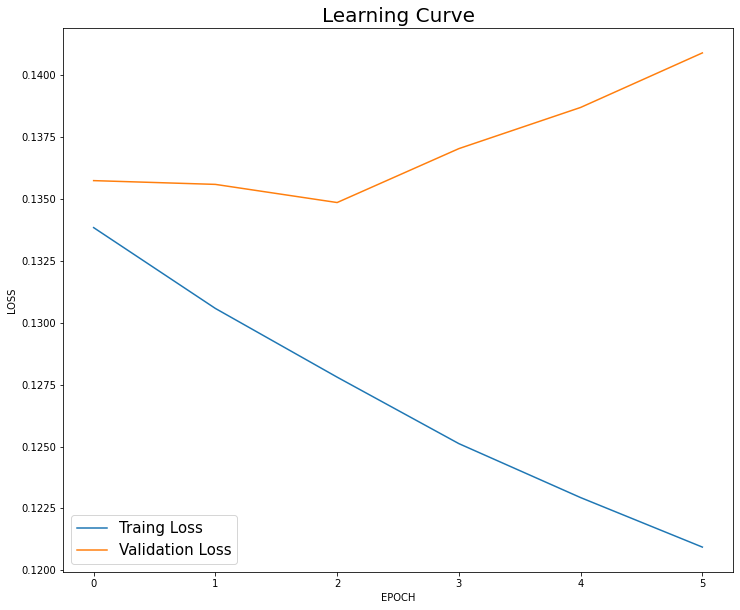

In [104]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_loss, label='Traing Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('EPOCH', size='10')
plt.ylabel('LOSS', size='10')
plt.title('Learning Curve', size='20')
plt.legend(loc='lower left', fontsize=15)

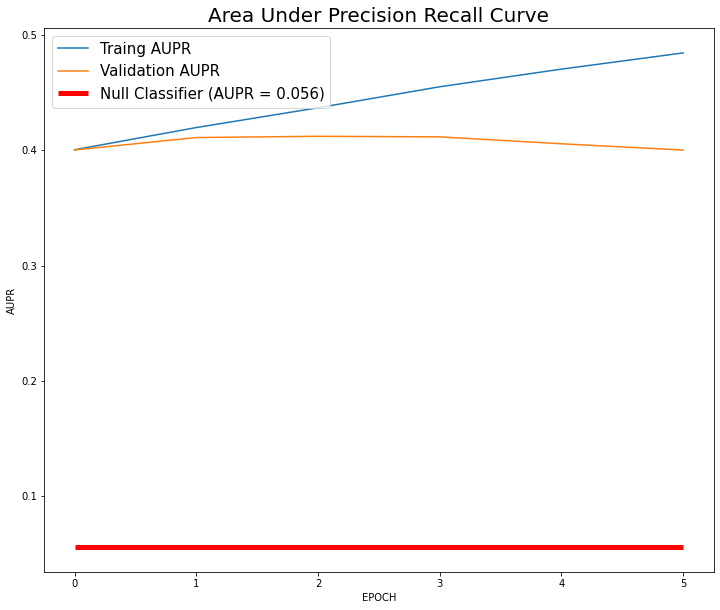

In [105]:
fig = plt.figure(figsize=(12,10))
plt.plot(training_aupr, label='Traing AUPR')
plt.plot(validation_aupr, label='Validation AUPR')
plt.hlines(0.056, 0.0, 5.0, colors='red', label="Null Classifier (AUPR = 0.056)", linewidth=5)
plt.xlabel('EPOCH', size='10')
plt.ylabel('AUPR', size='10')
plt.title('Area Under Precision Recall Curve', size='20')
plt.legend(loc='upper left', fontsize=15)

In [106]:
def print_conversion_metrics(y_true, y_pred_classes, y_pred_probs, title):
    cmtx = pd.DataFrame(
    confusion_matrix(y_true=y_true, y_pred=y_pred_classes), 
                     index=['true: not converted', 'true: converted'], columns=['pred: not converted', 'pred: converted'])
    print(title)
    print(cmtx)
    print('\n')
    print(classification_report(y_true, y_pred_classes))
    print(f'The area under the PR curve is approximately {average_precision_score(y_true, y_pred_probs, pos_label=1):1.2f}')
    

#### Now we create the confustion matrix for test

In [107]:
predictions_test = model.predict([data_dict['NAME_SENTENCE']['test'], 
           data_dict['ACTION_SENTENCE']['test'],
           data_dict['LABEL_SENTENCE']['test'],
           data_dict['DWELL_SENTENCE']['test'], 
           data_dict['TYPE_SENTENCE']['test'],
           data_dict['CATEGORY_SENTENCE']['test'],
           X_ip_test,
           X_sp_test,
           X_cust_test,
           X_channel_test,
           X_site_test,
           X_status_test,
           X_scaled_test[:,0],
           X_scaled_test[:,1],
           X_scaled_test[:,2],
                                 X_zip_test])


Instructions for updating:
use `experimental_local_results` instead.


In [122]:
predicted_classes_test = np.where(predictions_test > 0.335, 1, 0)

In [123]:
print_conversion_metrics(y_test, predicted_classes_test, predictions_test, 'Test Results')

Test Results
                     pred: not converted  pred: converted
true: not converted  535813               18390          
true: converted      18480                14320          


              precision    recall  f1-score   support

           0       0.97      0.97      0.97    554203
           1       0.44      0.44      0.44     32800

    accuracy                           0.94    587003
   macro avg       0.70      0.70      0.70    587003
weighted avg       0.94      0.94      0.94    587003

The area under the PR curve is approximately 0.41
